In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# 讀取資料
df = pd.read_excel("C://Users//User//Desktop//data_cln_complete.xlsx")
#pd.set_option('display.max_columns',None)
df.info()

# 複製資料
data = df.copy(deep=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1430 entries, 0 to 1429
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    1430 non-null   int64  
 1   product_title                 1430 non-null   object 
 2   price                         1430 non-null   float64
 3   retail_price                  1430 non-null   int64  
 4   units_sold                    1430 non-null   int64  
 5   uses_ad_boosts                1430 non-null   int64  
 6   rating                        1430 non-null   float64
 7   rating_count                  1430 non-null   int64  
 8   rating_five_count             1430 non-null   int64  
 9   rating_four_count             1430 non-null   int64  
 10  rating_three_count            1430 non-null   int64  
 11  rating_two_count              1430 non-null   int64  
 12  rating_one_count              1430 non-null   int64  
 13  bad

In [5]:
from sklearn.preprocessing import LabelEncoder

In [6]:
#drop 不必要的欄位 e.g. 商品id
modelData = data.drop(['product_title'], axis = 1)
modelData = modelData.drop(['tags'], axis = 1)
modelData = modelData.drop(['merchant_title', 'merchant_info_subtitle', 'product_id','urgency_text','theme'], axis = 1)

#為數值型資料做label
labelencoder = LabelEncoder()
modelData['product_color'] = labelencoder.fit_transform(modelData['product_color'].astype('str'))
modelData['product_variation_size_id'] = labelencoder.fit_transform(modelData['product_variation_size_id'].astype('str'))
modelData['origin_country'] = labelencoder.fit_transform(modelData['origin_country'].astype('str'))

modelData.head()

,Unnamed: 0,price,retail_price,units_sold,uses_ad_boosts,rating,rating_count,rating_five_count,rating_four_count,rating_three_count,...,product_variation_size_id,product_variation_inventory,shipping_price,shipping_is_express,countries_shipped_to,has_urgency_banner,origin_country,merchant_rating_count,merchant_rating,merchant_has_profile_picture
0,0,16.00,14,100,0,3.76,54,26,8,10,...,39,50,4,0,34,1,0,568,4.128521,0
1,1,8.00,22,20000,1,3.45,6135,2269,1027,1118,...,76,50,2,0,41,1,0,17752,3.899673,0
2,2,8.00,43,100,0,3.57,14,5,4,2,...,76,1,3,0,36,1,0,295,3.989831,0
3,3,8.00,8,5000,1,4.03,579,295,119,87,...,39,50,2,0,41,0,0,23832,4.020435,0
4,4,2.72,3,100,1,3.10,20,6,4,2,...,43,1,1,0,35,1,0,14482,4.001588,0


In [7]:
modelData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1430 entries, 0 to 1429
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    1430 non-null   int64  
 1   price                         1430 non-null   float64
 2   retail_price                  1430 non-null   int64  
 3   units_sold                    1430 non-null   int64  
 4   uses_ad_boosts                1430 non-null   int64  
 5   rating                        1430 non-null   float64
 6   rating_count                  1430 non-null   int64  
 7   rating_five_count             1430 non-null   int64  
 8   rating_four_count             1430 non-null   int64  
 9   rating_three_count            1430 non-null   int64  
 10  rating_two_count              1430 non-null   int64  
 11  rating_one_count              1430 non-null   int64  
 12  badges_count                  1430 non-null   int64  
 13  bad

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


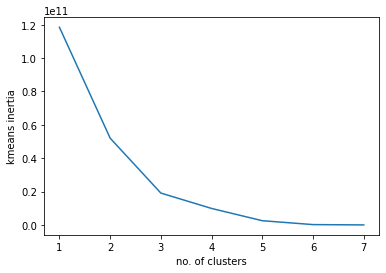

In [8]:
from sklearn.cluster import KMeans
#這邊的code的意思是說它會去找1~8的cluster分群的效果（手肘圖）
clusters = {}
for i in range(1,8):
    #************這邊fit進去重要的feature到model裡面！需調整*************
    kmeans = KMeans(n_clusters=i).fit(modelData[['units_sold','rating']])
    clusters[i] = kmeans.inertia_
    
plt.plot(list(clusters.keys()), list(clusters.values()));
#Inertia實際上計算cluster內所有點到該cluster的質心的距離的總和 （所以數值越大代表差距越大）
plt.xlabel('no. of clusters');
plt.ylabel('kmeans inertia');

In [9]:
#order cluster method
#只是將資料依照target欄位，將cluster結果做排序（可不用理會）
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [10]:
#實際將資料分三群
modelData['units_sold_cluster'] = KMeans(n_clusters=3).fit(modelData[['units_sold','rating']]).predict(modelData[['units_sold','rating']])
modelData = order_cluster('units_sold_cluster','units_sold', modelData, True)
modelData.groupby(['units_sold_cluster'])['units_sold'].describe()
display(modelData)
modelData.to_excel("Clustered.xlsx")

,Unnamed: 0,price,retail_price,units_sold,uses_ad_boosts,rating,rating_count,rating_five_count,rating_four_count,rating_three_count,...,product_variation_inventory,shipping_price,shipping_is_express,countries_shipped_to,has_urgency_banner,origin_country,merchant_rating_count,merchant_rating,merchant_has_profile_picture,units_sold_cluster
0,0,16.00,14,100,0,3.76,54,26,8,10,...,50,4,0,34,1,0,568,4.128521,0,0
1,2,8.00,43,100,0,3.57,14,5,4,2,...,1,3,0,36,1,0,295,3.989831,0,0
2,3,8.00,8,5000,1,4.03,579,295,119,87,...,50,2,0,41,0,0,23832,4.020435,0,0
3,4,2.72,3,100,1,3.10,20,6,4,2,...,1,1,0,35,1,0,14482,4.001588,0,0
4,5,3.92,9,10,0,5.00,1,1,0,0,...,1,1,0,40,0,0,65,3.507692,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1425,952,9.00,8,50000,0,3.83,13198,6060,2562,2214,...,50,3,0,53,0,0,37076,4.302082,1,2
1426,957,6.00,6,50000,0,4.20,12880,7337,2647,1643,...,18,2,0,53,0,0,38264,4.227943,0,2
1427,1028,11.00,10,50000,0,3.91,13488,6325,3006,1998,...,50,3,0,31,0,0,17816,4.179445,1,2
1428,1168,5.67,19,100000,0,3.53,18393,6769,3404,3658,...,50,1,0,37,1,0,19248,3.889131,0,2


In [14]:
modelData=modelData.groupby("units_sold_cluster")
display(modelData)

AttributeError: 'DataFrameGroupBy' object has no attribute 'groupby'